In [21]:
import numpy as np
from sortedcontainers import SortedSet
from math import sqrt

In [22]:
class MyPriorityQueue(object):
    def __init__(self, current_heuristic, target):
        self.current_heuristic = current_heuristic
        self._data = SortedSet()
        self.target = target
        self.g = dict()
        self.h = dict()
    def __len__(self):
        return len(self._data)
    def push(self, item):
        node = (self.calculate_priority(item), self.get_heuristic(item), item)
        self._data.add(node)
    def pop(self):
        node = self._data.pop(0)[2]
        return node
    def manhattan_distance(self, x, y): ### Manhattan Distance-> heuristic = |x0-y0| + |x1-y1|, x = [x0,x1] y = [y0,y1]
        return abs(x[0] - y[0]) +abs(x[1] - y[1])
    def euclidean_distance(self, x, y): ### Euclidean Distance-> heuristic = sqrt( (x0-y0)**2 + (x1-y1)**2 ), x = [x0,x1]
                                        ##  y = [y0,y1]
        return sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    def chebyshev_distance(self, x, y): ### Chebyshev Distance-> heuristic = max(abs(x0-y0),abs(x1-y1)),
                                        ### x = [x0,x1] y = [y0,y1]
        return max(abs(x[0] - x[1]), abs(y[0] - y[1]))
    def get_heuristic(self, x):
        measure = self.current_heuristic
        if measure == 'm':
            self.h[x] = self.manhattan_distance(x, self.target)
        elif measure == 'e':
            self.h[x] = self.euclidean_distance(x, self.target)
        elif measure == 'c':
            self.h[x] = self.chebyshev_distance(x, self.target)
        return self.h[x]
    def calculate_priority(self, x):
        return self.g[x] + self.get_heuristic(x)

In [23]:
class GridWorld:
    def __init__(self, grid, start, target, n, m):
        '''
        Notations in grid: If grid contains 0, it means the cell is empty
                            and if the grid contains 1, it means the cell is blocked
                            and if the grid contains -1, it means the cell is unconfirmed
        '''
        self.n = n ## Number of columns
        self.m = m ## Number of rows
        self.start = start  ## Starting cell of the agent
        self.target = target ## Target cell of the agent
        self.trajectory = [] ## Trajectory followed by the agent
        self.grid = grid  ## Grid containing complete knowledge
        self.dirx8 = [0, 0, 1, -1, 1, -1, 1, -1] ## Directions used for sensing
        self.diry8 = [1, -1, 0, 0, 1, -1, -1, 1] ## Directions used for sensing
        self.dirx4 = [0, 0, 1, -1]  ## Directions used for traversing
        self.diry4 = [1, -1, 0, 0]  ## Directions used for traversing
        self.sensed_x = set() ## List of cells sensed by agent
        self.status_x = {} ## Denotes the status of the cell. 1-> confirmed block, 0-> confirmed unblocked, 
                            ## -1 -> unconfirmed
        self.cx = {}
    def pre_computation(self):
        for i in np.arange(self.m):
            for j in np.arange(self.n):
                nx = 0
                for k in np.arange(8):
                    childx = i + self.dirx8[k]
                    childy = j + self.diry8[k]
                    if(childx>=0 and childx<self.m and childy>=0 and childy<self.n):
                        nx+=1
                cell = (i,j)
                self.nx[cell] = nx
                self.hx[cell] = nx
            
    def partial_sensing(self, cell, agentGridObject):
        ''' 
            Returns number of cells that are blocked by accessing true grid
            Calculates number of neighbours of a cell
            Calculates cx
        '''
        x = cell[0]
        y = cell[1]
        cx = 0
        for i in np.arange(8):
            childx = x + self.dirx8[i]
            childy = y + self.diry8[i]
            if(childx >= 0 and childx < self.m and childy>=0 and childy<self.n):
                if(self.grid[childx][childy] == '1'):
                    cx+=1
        agentGridObject.cx[cell] = cx ## Updating partial sensing information for the agent
        agentGridObject.sensed_x.add(cell) ## Adding cell to the set of sensed cells
        return cx
    def visit_cell(self, cell, agentGridObject):
        '''
            If the agent goes to the next cell, it will get sense whether the next cell is blocked or not
        '''
        x = cell[0]
        y = cell[1]
        agentGridObject.status_x[cell] = int(self.grid[x][y])
        agentGridObject.grid[x][y] = self.grid[x][y]
        return int(self.grid[x][y])

In [24]:
from collections import deque
class Inference_Agent4:
    def __init__(self, agentGridObject,m,n):
        self.agentGridObject = agentGridObject # Object representing the gridworld of the Agent
        self.dirx8 = [0, 0, 1, -1, 1, -1, 1, -1] # Direction used for sensing
        self.diry8 = [1, -1, 0, 0, 1, -1, -1 ,1] # Direction used for sensing
        self.kb_eqns = [] ## This is list of equation. One equation is represented as a list where first element is a set
                          ## of tuples and the second element is the value.
        self.q = deque()
        self.m = m
        self.n = n
    def mark_cell(self, type_, cell):
        currx = cell[0]
        curry = cell[1]
        cell = (currx, curry)
        if(type_ == 1):
            self.agentGridObject.status_x[cell] = 1
            self.agentGridObject.grid[currx][curry] = '1'
        else:
            self.agentGridObject.status_x[cell] = 0
            self.agentGridObject.grid[currx][curry] = '0'
    def put_val_kb(self):
        '''
        This function checks for each eqn in kb_eqns and updates each equation according to the current knowledge of the 
        agent. The new equation is removed from knowledge base and added in the queue.
        '''
        
        idx = 0
        for eqn in self.kb_eqns:
            var = eqn[0] ## This is a set of tuples
            val = eqn[1] ## This is the value in RHS
            flag = False
            new_eqn = set()
            for cell in var:
                if cell in self.agentGridObject.status_x and self.agentGridObject.status_x[cell]!=-1:
                    change= self.agentGridObject.status_x[cell]
#                     print("put value change: ", change," cell: ",cell)
                    val = val - change
                    flag= True
                else:
                    new_eqn.add(cell)
#             print("old_eqn: ",eqn," new_eqn: ",new_eqn)
            if(flag):
                self.kb_eqns.pop(idx)
                self.q.appendleft([new_eqn,val])
            idx+=1
    def get_eqn_current_cell(self, cell):
        '''
            Generate an equation for a cell, according to the current knowledge of the agent.
        '''
        var = set()
        val = self.agentGridObject.cx[cell]
        currx = cell[0]
        curry = cell[1]
        for i in np.arange(8):
            childx = currx + self.dirx8[i]
            childy = curry + self.diry8[i]
            child = (childx,childy)
            if(childx>=0 and childx<self.m and childy>=0 and childy<self.n):
                if(child not in self.agentGridObject.status_x or self.agentGridObject.status_x[child] == -1):
                    var.add(child)
                else:
                    val = val - self.agentGridObject.status_x[child]
        return var, val
    def check_solvability(self, eqn):
        '''
            Check whether the current equation is solvable of not.
            Two cases:
            if number of variables == val --> then all the value of variables is 1.
            if val == 0 --> then the value of all variables is 0
        '''
        var = eqn[0]
        val = eqn[1]
        flag = False
        if(len(var) == val):
            ### All the variables are equal to 1
            flag = True
            for cell in var:
                currx = cell[0]
                curry = cell[1]
                self.agentGridObject.status_x[cell] = 1
                self.agentGridObject.grid[currx][curry] = '1'
#                 print("^^^^^^^^^^^^^^^^^^^^^^^currx: ",currx," curry: ",curry)
        elif(val == 0):
            ### All the variables are equal to 0
            flag = True
            for cell in var:
                currx = cell[0]
                curry = cell[1]
                self.agentGridObject.grid[currx][curry] = '0'
                self.agentGridObject.status_x[cell] = 0
        return flag
    def simplify_eqn(self, eqn):
        '''
            Simplifies the equation, according to the current knowledge of the grid.
        '''
        var = eqn[0]
        val = eqn[1]
        new_eqn = set()
        for cell in var:
            if(cell in self.agentGridObject.status_x and self.agentGridObject.status_x[cell]>=0):
                val = val - self.agentGridObject.status_x[cell]
            else:
                new_eqn.add(cell)
        return [new_eqn, val]
    def check_subsequence(self, eqn1, eqn2):
        '''
            Check if eqn2 is subsequence of eqn1
        '''
        var1 = eqn1[0] 
        val1 = eqn1[1]
        var2 = eqn2[0]
        val2 = eqn2[1]
        return var2.issubset(var1)
    def simplify_kb_subsequence(self, q_eqn):
        idx = 0
        flag = True ### Denotes whether the current equation will be added to KB or not
        for kb_eqn in self.kb_eqns:
            if(kb_eqn==q_eqn): ############
#                 print("-----same equations-----")
                flag = False
                break          ############
            res = self.check_subsequence(kb_eqn, q_eqn) ## Will be True if q_eqn is subsequence of kb_eqn
            var_kb = kb_eqn[0]
            val_kb = kb_eqn[1]
            var_q = q_eqn[0]
            val_q = q_eqn[1]
            if(res == True):
                #######  No. 2 ######## Will reduce the eqn of KB
                self.kb_eqns.pop(idx)
                new_eq_kb = var_kb.difference(var_q)
                new_val_kb = val_kb - val_q
                if( len(new_eq_kb) == 1 ):
                    single_var = next(iter(new_eq_kb))
                    self.agentGridObject.status_x[single_var] = new_val_kb
                    self.agentGridObject.grid[single_var[0]][single_var[1]] = str(new_val_kb)
                else:
                    self.q.append([new_eq_kb,new_val_kb])
            res = self.check_subsequence(q_eqn, kb_eqn) ## Will be True if kb_eqn is subsequence of q_eqn
            if(res == True):
                flag = False
                ####### No. 1 ######### Will reduce the eqn of queue
                new_q_eqn = var_q.difference(var_kb)
                new_q_val = val_q - val_kb
                self.q.appendleft([new_q_eqn, new_q_val])
            idx += 1
        self.put_val_kb()
        return flag
    def simplify_kb_setDiff(self, eqn):
        var_q = eqn[0]
        val_q = eqn[1]
        flag = True
        for kb_eqn in self.kb_eqns:
            var_kb = kb_eqn[0]
            val_kb = kb_eqn[1]
            ##### We choose first and secnod s.t. first[1]-second[1] = rhs>=0
            first = eqn
            second = kb_eqn
            if(first[1]-second[1]<0):
                temp = first
                first = second
                second = temp
            rhs = first[1] - second[1]
            lhs = first[0].difference(second[0])
            if(len(lhs) == rhs):
                flag = False
                neg_lhs = second[0].difference(first[0])
                for cell in lhs:
                    self.agentGridObject.status_x[cell] = 1
                    self.agentGridObject.grid[cell[0]][cell[1]] = '1'
                for cell in neg_lhs:
                    self.agentGridObject.status_x[cell] = 0
                    self.agentGridObject.grid[cell[0]][cell[1]] = '0'
        self.put_val_kb()
        return flag
            
    def infer(self, type_, cell):
        m = self.agentGridObject.m
        n = self.agentGridObject.n
        '''
        Function starts inferrencing from the node that is present in planned_path. First, we will mark the cell and update
        the value of current cell in knowledge base equations.
        '''
        self.mark_cell(type_, cell) ## This function marks the current cell as blocked or unblocked
        self.put_val_kb()
        var, val = self.get_eqn_current_cell(cell)
        self.q.append([var,val])
        while(len(self.q)>0):
            eqn = self.q.popleft()
            eqn = self.simplify_eqn(eqn)
            flag = self.check_solvability(eqn)
            if(flag):
                self.put_val_kb()
                continue
            add_to_KB1 = self.simplify_kb_subsequence(eqn)
            add_to_KB2 = self.simplify_kb_setDiff(eqn)
            if( add_to_KB1 and add_to_KB2 ):
                self.kb_eqns.append(eqn)

In [25]:
class Agent4:
    def __init__(self, n, m, start, target, inference_agent, grid,agent_grid):
        self.n = n ## Number of columns in grid
        self.m = m ## Number of rows in the grid
        self.start = start ## The start cell of the grid
        self.target = target ## The target cell of the grid
        self.agent_grid = agent_grid  ## The current knowledge of the agent_grid
        self.dirx4 = [-1,1,0,0] ## 4 Directions for the agent to travel
        self.diry4 = [0,0,-1,1] ## 4 Directions for the agent to travel
        self.inference_agent = inference_agent
        self.grid = grid # The full knowledge of the maze
        self.num_bumps = 0 ## Number of bumps in planned_path
        self.sum_num_cells_processed = 0
        self.sum_a_star = 0
        self.lim_inference = 50
    def a_star(self, source, current_heuristic = 'm'):
        '''
            A-star algorithm that plans path based on current knowledge of the agent
        '''
        dirx = [-1, 1, 0, 0] ## calculates the neighbours of the current node
        diry = [0, 0, 1, -1] ## calculates the neighbours of the current node
        visited = set() ## contains the nodes that have already been added in priority queue
        closed_list = set() ## contains the nodes that have been popped from priority queue
        open_list = MyPriorityQueue(current_heuristic, self.target) ## stores the visited nodes and pops it out 
                                                                    ## according to it's priority
        planned_path = [] ## Stores the path that the agent has planned according to it's current knowledge
        open_list.g[source]=0
        open_list.calculate_priority( source)
        open_list.push( source) ## This function runs in O(logn)
        visited.add(source) #visited[source] = 1
        parent = {} ## stores the parent of each node that is visited
        parent[source] = None
        while(len(open_list)>0):
            curr = open_list.pop()
            self.sum_num_cells_processed+=1
            closed_list.add(curr)
            if(curr[0] == self.target[0] and curr[1] == self.target[1]):
                break
            for i in np.arange(4):
                childx = curr[0] + dirx[i]
                childy = curr[1] + diry[i]
                child = (childx, childy)
                if(childx>=0 and childx<self.m and childy>=0 and childy<self.n and (child not in closed_list) and self.agent_grid.grid[childx][childy]!='1'):
                    if(child not in visited):
                        visited.add(child)
                        parent[child] = curr
                        open_list.g[child] = open_list.g[curr]+1
                        open_list.calculate_priority(child)
                        open_list.push(child) 
                    else:
                        if open_list.g[curr]+1<open_list.g[child]:
                            parent[child] = curr
                            open_list._data.discard(child)
                            open_list.g[child] = open_list.g[curr]+1
                            open_list.calculate_priority(child)
                            open_list.push(child)
        if(self.target not in visited):
            return []
        curr = self.target
        while(curr != source):
            planned_path.append(curr)
            curr = parent[curr]
        planned_path.append(source)
        return planned_path[::-1]
    def check_planned_path(self, planned_path):
        '''
            The agent should call the inference agent after visiting every cell and the inference agent updates the current
            knowledge of the agent. If the agent sees, that a node in the planned_path is blocked, then the agent will 
            start A-star again from the current node.
            
            There will be two types of updates in the current cell->
            Type-0: The current node is set to unblocked, need to update the neighbours accordingly and propagate.
            Type-1: The current node is set to blocked, need to update the neighbours accordingly and propagate.
        '''
        n = len(planned_path)
        traversed_path = []
        restart_cell = None
        for i in np.arange(n):
            cell = planned_path[i]
            currx = cell[0]
            curry = cell[1]
            ## We will start inference only if the next cell is not sensed since if the cell is already sensed then there
            ## will be no update in current knowledge.
            if( cell not in self.agent_grid.sensed_x):
                curr_status = self.grid.visit_cell(cell, self.agent_grid) ## Checking whether curr cell is blocked or not.
                self.grid.partial_sensing(cell, self.agent_grid) ## Cell is sensed only if it is not sensed or inferred before
                self.agent_grid.grid[currx][curry] = str(curr_status) ## updating the agent_grid for the current cell.
                start
                self.inference_agent.infer(curr_status,cell) ##Start inferring about x
            else:
                curr_status =  self.agent_grid.status_x[cell]
            if(curr_status == 1):
                self.num_bumps += 1
                restart_cell = planned_path[i-1]
                break
            ### the current node is unblocked so if the node in the planned_path is blocked, 
            ### then we need to update the restart node and break from this loop
            ### Will check only the 4 nodes ahead of the current node, since, the inference 
            ### agent will not update beyond 4 nodes
            planned_path_blocked = False
#             print("self.agent_grid.status_x: ",self.agent_grid.status_x)
#             print("self.agent_grid: ",self.agent_grid.grid)
            for j in np.arange(4):
                if(i+j+1 >= n):
                    break
                next_cell = planned_path[i+j+1]
                next_x = next_cell[0]
                next_y = next_cell[1]
                if(self.agent_grid.grid[next_x][next_y] == '1'):
                    planned_path_blocked = True
                    break
            if(planned_path_blocked == True):
                restart_cell = cell
                traversed_path.append(cell)
                break
            traversed_path.append(cell)
        return traversed_path, restart_cell
            
    def compute_path(self):
        '''
        
        '''
        path = []
        curr = self.start
        while(curr != self.target):
            self.sum_a_star+=1
            planned_path = self.a_star(curr)
            if( len(planned_path) == 0 ):
                return []
            traversed_path, restart_node = self.check_planned_path(planned_path)
            n = len(traversed_path)
            path.append(traversed_path)
            if(traversed_path[n-1] == self.target):
                break
            curr = restart_node
        return path

In [26]:
grid = '....XXXX..XX......X....XX.XXX..X....X.....XXXX..X.X..XX...X...XX..XX.....X.X...XXX.X.X.X.X.X...X.X..'
s = ''
cnt =0
for x in grid:
    if(x == '.'):
        s = s + '0'
    else:
        cnt+=1
        s = s + '1'
print(len(s))
print(cnt)

100
39


In [27]:
2998/10201

0.29389275561219486

In [28]:
n = 10
grid = [] ## matrix that contains full knowledge of gridworld
i = 0
while(i<n*n):
    grid.append(list(s[i:i+n]))
    i = i + n
grid = np.array(grid)
print(grid)

[['0' '0' '0' '0' '1' '1' '1' '1' '0' '0']
 ['1' '1' '0' '0' '0' '0' '0' '0' '1' '0']
 ['0' '0' '0' '1' '1' '0' '1' '1' '1' '0']
 ['0' '1' '0' '0' '0' '0' '1' '0' '0' '0']
 ['0' '0' '1' '1' '1' '1' '0' '0' '1' '0']
 ['1' '0' '0' '1' '1' '0' '0' '0' '1' '0']
 ['0' '0' '1' '1' '0' '0' '1' '1' '0' '0']
 ['0' '0' '0' '1' '0' '1' '0' '0' '0' '1']
 ['1' '1' '0' '1' '0' '1' '0' '1' '0' '1']
 ['0' '1' '0' '0' '0' '1' '0' '1' '0' '0']]


In [29]:
grid = np.array([
    ['0','0','0','0','0'],
    ['0','0','0','0','0'],
    ['0','0','0','1','0'],
    ['0','0','0','0','0'],
    ['0','0','0','0','0']
])

In [30]:
n = 5
m = 5
start = (0,0)
target = (m-1,n-1)
gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
inference_agent = Inference_Agent4(agentGridObject,m,n) ### AgentGrid
grid_agent = Agent4(n,m,start,target,inference_agent,gridObject, agentGridObject)
grid_agent.compute_path()
print(grid_agent.num_bumps)

0


In [13]:
import numpy as np
p_values = np.linspace(0,0.3,31)
print(p_values)
result_x = p_values[1:50]

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3 ]


In [14]:
### Plots --> avg len of trajectory, avg number of cells processed, avg num of bumps

def calculate_path_length(ans_compute_path):
    ans = 0
    for x in ans_compute_path:
        ans = ans + len(x)-1
    return ans + 1
from tqdm import tqdm
cnt = 0
result_y = []
# p_values = np.round(p_values,2)
# result_x = p_values[1:50]
avg_num_cells_processed = []
avg_bumps = []
avg_astar = []
m = 101
n = 101
start = (0,0)
target = (m-1,n-1)
for p in tqdm(p_values):
    if p == 0 or  p== 1:
        continue
    print("Started for p: ",p)
    sum_num_cells_processed = 0
    sum_bumps = 0
    sum_astar = 0
    cnt = 0
    with open('C:/Users/karan/Desktop/Rutgers Courses/CS520/Project2/Grid_data/'+'p'+str(p)+'.txt') as f:
        grid_data = f.readlines()
        freq = 0
        for s in grid_data:
            new_s = ''
            for c in s:
                if(c == '.'):
                    new_s +='0'
                else:
                    new_s += '1'
            i = 0
            grid = [] ## matrix that contains full knowledge of gridworld
            m = 101
            n = 101
            start = (0,0)
            target = (m-1,n-1)
            while(i<m*n):
                grid.append(list(new_s[i:i+n]))
                i = i + n
            grid = np.array(grid)
            gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
            agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
            inference_agent = Inference_Agent4(agentGridObject,m,n) ### Inference Agent Grid
            grid_agent = Agent4(n,m,start,target,inference_agent,gridObject, agentGridObject)
            ans = grid_agent.compute_path()
            sum_num_cells_processed += grid_agent.sum_num_cells_processed
            sum_bumps += grid_agent.num_bumps
            sum_astar += grid_agent.sum_a_star
            cnt+=1
            if(cnt == 250):
                break
        avg_num_cells_processed.append(sum_num_cells_processed/250)
        avg_bumps.append(sum_bumps/250)
        avg_astar.append(sum_astar/250)
        print(sum_bumps)
        print(sum_bumps/250)
        

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Started for p:  0.01


  6%|█████▎                                                                             | 2/31 [00:05<01:12,  2.51s/it]

483
1.932
Started for p:  0.02


 10%|████████                                                                           | 3/31 [00:11<01:57,  4.19s/it]

1017
4.068
Started for p:  0.03


 13%|██████████▋                                                                        | 4/31 [00:19<02:29,  5.55s/it]

1451
5.804
Started for p:  0.04


 16%|█████████████▍                                                                     | 5/31 [00:29<03:00,  6.96s/it]

1962
7.848
Started for p:  0.05


 19%|████████████████                                                                   | 6/31 [00:42<03:47,  9.09s/it]

2490
9.96
Started for p:  0.06


 23%|██████████████████▋                                                                | 7/31 [00:58<04:31, 11.32s/it]

2997
11.988
Started for p:  0.07


 26%|█████████████████████▍                                                             | 8/31 [01:16<05:09, 13.47s/it]

3497
13.988
Started for p:  0.08


 29%|████████████████████████                                                           | 9/31 [01:36<05:42, 15.58s/it]

3931
15.724
Started for p:  0.09


 32%|██████████████████████████▍                                                       | 10/31 [01:59<06:13, 17.80s/it]

4484
17.936
Started for p:  0.1


 35%|█████████████████████████████                                                     | 11/31 [02:24<06:37, 19.88s/it]

4966
19.864
Started for p:  0.11


 39%|███████████████████████████████▋                                                  | 12/31 [02:51<07:00, 22.13s/it]

5578
22.312
Started for p:  0.12


 42%|██████████████████████████████████▍                                               | 13/31 [03:21<07:19, 24.39s/it]

6214
24.856
Started for p:  0.13


 45%|█████████████████████████████████████                                             | 14/31 [03:52<07:31, 26.57s/it]

6760
27.04
Started for p:  0.14


 48%|███████████████████████████████████████▋                                          | 15/31 [04:27<07:43, 28.95s/it]

7323
29.292
Started for p:  0.15


 52%|██████████████████████████████████████████▎                                       | 16/31 [05:04<07:53, 31.55s/it]

7921
31.684
Started for p:  0.16


 55%|████████████████████████████████████████████▉                                     | 17/31 [05:46<08:02, 34.48s/it]

8699
34.796
Started for p:  0.17


 58%|███████████████████████████████████████████████▌                                  | 18/31 [06:30<08:05, 37.34s/it]

9030
36.12
Started for p:  0.18


 61%|██████████████████████████████████████████████████▎                               | 19/31 [07:18<08:07, 40.64s/it]

9952
39.808
Started for p:  0.19


 65%|████████████████████████████████████████████████████▉                             | 20/31 [08:08<07:57, 43.45s/it]

10245
40.98
Started for p:  0.2


 68%|███████████████████████████████████████████████████████▌                          | 21/31 [09:02<07:45, 46.55s/it]

11311
45.244
Started for p:  0.21


 71%|██████████████████████████████████████████████████████████▏                       | 22/31 [10:00<07:29, 49.95s/it]

12179
48.716
Started for p:  0.22


 74%|████████████████████████████████████████████████████████████▊                     | 23/31 [10:58<07:00, 52.57s/it]

12417
49.668
Started for p:  0.23


 77%|███████████████████████████████████████████████████████████████▍                  | 24/31 [12:05<06:37, 56.73s/it]

13682
54.728
Started for p:  0.24


 81%|██████████████████████████████████████████████████████████████████▏               | 25/31 [13:16<06:06, 61.15s/it]

14768
59.072
Started for p:  0.25


 84%|████████████████████████████████████████████████████████████████████▊             | 26/31 [14:30<05:24, 64.98s/it]

15364
61.456
Started for p:  0.26


 87%|███████████████████████████████████████████████████████████████████████▍          | 27/31 [15:50<04:37, 69.42s/it]

16492
65.968
Started for p:  0.27


 90%|██████████████████████████████████████████████████████████████████████████        | 28/31 [17:15<03:42, 74.01s/it]

17306
69.224
Started for p:  0.28


 94%|████████████████████████████████████████████████████████████████████████████▋     | 29/31 [18:47<02:39, 79.51s/it]

18950
75.8
Started for p:  0.29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [20:25<01:24, 84.99s/it]

19866
79.464
Started for p:  0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [22:13<00:00, 43.02s/it]

21975
87.9


In [167]:
### Plots --> avg len of trajectory, avg number of cells processed, avg num of bumps

def calculate_path_length(ans_compute_path):
    ans = 0
    for x in ans_compute_path:
        ans = ans + len(x)-1
    return ans + 1
from tqdm import tqdm
cnt = 0
result_y = []
# p_values = np.round(p_values,2)
# result_x = p_values[1:50]
avg_num_cells_processed = []
avg_bumps = []
avg_astar = []
m = 101
n = 101
start = (0,0)
target = (m-1,n-1)
for p in tqdm(p_values):
    if p == 0 or  p== 1:
        continue
    print("Started for p: ",p)
    sum_num_cells_processed = 0
    sum_bumps = 0
    sum_astar = 0
    cnt = 0
    with open('C:/Users/karan/Desktop/Rutgers Courses/CS520/Project2/Grid_data/'+'p'+str(p)+'.txt') as f:
        grid_data = f.readlines()
        freq = 0
        for s in grid_data:
            new_s = ''
            for c in s:
                if(c == '.'):
                    new_s +='0'
                else:
                    new_s += '1'
            i = 0
            grid = [] ## matrix that contains full knowledge of gridworld
            m = 101
            n = 101
            start = (0,0)
            target = (m-1,n-1)
            while(i<m*n):
                grid.append(list(new_s[i:i+n]))
                i = i + n
            grid = np.array(grid)
            gridObject = GridWorld(grid, start, target, n, m) ### Original grid knowledge object
            agentGridObject = GridWorld(np.full((m,n),'0'), start, target, n, m) ### Agent Grid Object
            inference_agent = Inference_Agent4(agentGridObject,m,n) ### Inference Agent Grid
            grid_agent = Agent4(n,m,start,target,inference_agent,gridObject, agentGridObject)
            ans = grid_agent.compute_path()
            sum_num_cells_processed += grid_agent.sum_num_cells_processed
            sum_bumps += grid_agent.num_bumps
            sum_astar += grid_agent.sum_a_star
            cnt+=1
            if(cnt == 250):
                break
        avg_num_cells_processed.append(sum_num_cells_processed/250)
        avg_bumps.append(sum_bumps/250)
        avg_astar.append(sum_astar/250)
        print(sum_bumps)
        print(sum_bumps/250)
        

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]

Started for p:  0.01


  6%|█████▎                                                                             | 2/31 [00:22<05:28, 11.31s/it]

483
1.932
Started for p:  0.02


 10%|████████                                                                           | 3/31 [00:49<08:17, 17.76s/it]

1017
4.068
Started for p:  0.03


 13%|██████████▋                                                                        | 4/31 [01:23<10:42, 23.80s/it]

1451
5.804
Started for p:  0.04


 16%|█████████████▍                                                                     | 5/31 [02:01<12:26, 28.72s/it]

1962
7.848
Started for p:  0.05


 19%|████████████████                                                                   | 6/31 [02:45<14:09, 33.97s/it]

2490
9.96
Started for p:  0.06


 23%|██████████████████▋                                                                | 7/31 [03:35<15:36, 39.01s/it]

2997
11.988
Started for p:  0.07


 26%|█████████████████████▍                                                             | 8/31 [04:30<16:55, 44.16s/it]

3497
13.988
Started for p:  0.08


 29%|████████████████████████                                                           | 9/31 [05:31<18:04, 49.30s/it]

3931
15.724
Started for p:  0.09


 32%|██████████████████████████▍                                                       | 10/31 [06:40<19:23, 55.39s/it]

4484
17.936
Started for p:  0.1


 35%|█████████████████████████████                                                     | 11/31 [07:57<20:39, 62.00s/it]

4966
19.864
Started for p:  0.11


 39%|███████████████████████████████▋                                                  | 12/31 [09:19<21:33, 68.09s/it]

5578
22.312
Started for p:  0.12


 42%|██████████████████████████████████▍                                               | 13/31 [10:51<22:32, 75.13s/it]

6214
24.856
Started for p:  0.13


 45%|█████████████████████████████████████                                             | 14/31 [12:31<23:25, 82.66s/it]

6760
27.04
Started for p:  0.14


 48%|███████████████████████████████████████▋                                          | 15/31 [14:16<23:52, 89.55s/it]

7323
29.292
Started for p:  0.15


 52%|██████████████████████████████████████████▎                                       | 16/31 [16:09<24:07, 96.51s/it]

7921
31.684
Started for p:  0.16


 55%|████████████████████████████████████████████▉                                     | 17/31 [17:54<23:05, 98.93s/it]

8699
34.796
Started for p:  0.17


 58%|███████████████████████████████████████████████                                  | 18/31 [19:57<23:01, 106.28s/it]

9030
36.12
Started for p:  0.18


 61%|█████████████████████████████████████████████████▋                               | 19/31 [21:29<20:24, 102.01s/it]

9952
39.808
Started for p:  0.19


 65%|████████████████████████████████████████████████████▉                             | 20/31 [21:53<14:23, 78.47s/it]

10245
40.98
Started for p:  0.2


 68%|███████████████████████████████████████████████████████▌                          | 21/31 [22:18<10:25, 62.58s/it]

11311
45.244
Started for p:  0.21


 71%|██████████████████████████████████████████████████████████▏                       | 22/31 [22:46<07:50, 52.24s/it]

12179
48.716
Started for p:  0.22


 74%|████████████████████████████████████████████████████████████▊                     | 23/31 [23:16<06:03, 45.44s/it]

12417
49.668
Started for p:  0.23


 77%|███████████████████████████████████████████████████████████████▍                  | 24/31 [23:48<04:50, 41.54s/it]

13682
54.728
Started for p:  0.24


 81%|██████████████████████████████████████████████████████████████████▏               | 25/31 [24:24<03:59, 39.86s/it]

14768
59.072
Started for p:  0.25


 84%|████████████████████████████████████████████████████████████████████▊             | 26/31 [25:02<03:15, 39.10s/it]

15364
61.456
Started for p:  0.26


 87%|███████████████████████████████████████████████████████████████████████▍          | 27/31 [25:43<02:38, 39.68s/it]

16492
65.968
Started for p:  0.27


 90%|██████████████████████████████████████████████████████████████████████████        | 28/31 [26:26<02:02, 40.83s/it]

17306
69.224
Started for p:  0.28


 94%|████████████████████████████████████████████████████████████████████████████▋     | 29/31 [27:14<01:25, 42.94s/it]

18950
75.8
Started for p:  0.29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 30/31 [28:05<00:45, 45.49s/it]

19866
79.464
Started for p:  0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [29:03<00:00, 56.24s/it]

21975
87.9


In [16]:
import pickle
with open('agent_2_avg_bumps.pkl', 'rb') as f:
    agent_2_avg_bumps = pickle.load(f)
with open('agent_1_avg_bumps.pkl', 'rb') as f:
    agent_1_avg_bumps = pickle.load(f)
with open('agent_3_avg_bumps.pkl', 'rb') as f:
    agent_3_avg_bumps = pickle.load(f)

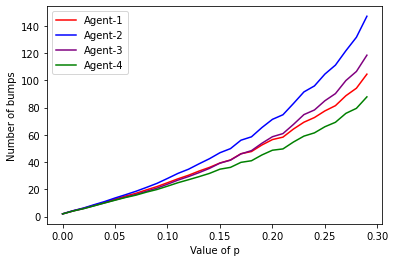

In [17]:
import matplotlib.pyplot as plt
plt.plot(p_values[:-1], agent_1_avg_bumps,color = "red", label="Agent-1")
plt.plot(p_values[:-1], agent_2_avg_bumps,color = "blue", label="Agent-2")
plt.plot(p_values[:-1], agent_3_avg_bumps,color = "purple", label="Agent-3")
plt.plot(p_values[:-1], avg_bumps,color = "green", label="Agent-4")
plt.xlabel('Value of p')
plt.ylabel('Number of bumps')
plt.legend()

In [18]:
np.array(avg_bumps) - np.array(agent_1_avg_bumps)

array([ -0.024,  -0.116,  -0.272,  -0.456,  -0.48 ,  -0.852,  -1.036,
        -1.348,  -1.66 ,  -2.152,  -2.528,  -2.876,  -3.284,  -4.088,
        -4.416,  -4.536,  -5.432,  -6.34 ,  -6.768,  -7.32 ,  -7.816,
        -8.652,  -9.532, -10.216, -11.252, -11.624, -12.204, -12.952,
       -14.788, -16.68 ])

In [168]:
agent_1_avg_bumps

[1.956,
 4.184,
 6.076,
 8.304,
 10.44,
 12.84,
 15.024,
 17.072,
 19.596,
 22.016,
 24.84,
 27.732,
 30.324,
 33.38,
 36.1,
 39.332,
 41.552,
 46.148,
 47.748,
 52.564,
 56.532,
 58.32,
 64.26,
 69.288,
 72.708,
 77.592,
 81.428,
 88.752,
 94.252,
 104.58]

In [19]:
# import pickle
# with open('Agent-4-inference-done-on-negative.pkl', 'wb') as f:
#        pickle.dump(avg_bumps, f)